# Modélisation

## 1. ⚙️ Préparation

### 🔹 Objectif

Charger les données traitées (`data/processed/`), séparer les variables explicatives (features) de la variable cible (target), puis diviser les données en ensembles d'entraînement et de validation. On fixe également une graine aléatoire pour assurer la reproductibilité des résultats.

In [62]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
# 2. Fixer la seed pour reproductibilité
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
TARGET_NAME = "SalePrice"

# 3. Charger les données traitées
# Répertoire des données
DATA_DIR = Path("./../data/")
PROCESSED_DIR = DATA_DIR / "processed"

# Chargement des fichiers
X = pd.read_csv(PROCESSED_DIR / "X_train_processed.csv")
y = pd.read_csv(PROCESSED_DIR / "y_train.csv").squeeze()  # .squeeze() pour avoir une Series si 1 seule colonne

**Split en train / validation**

In [64]:
# 6. Split des données
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_test, X_val, y_test, y_val = train_test_split(
    X_val, y_val, test_size=0.5, random_state=SEED)

print("Taille X_train :", X_train.shape)
print("Taille X_val   :", X_val.shape)
print("Taille X_test  :", X_test.shape)

Taille X_train : (1168, 75)
Taille X_val   : (146, 75)
Taille X_test  : (146, 75)


## 2. Exploration rapide

###  Objectif

Faire une analyse rapide des données d'entraînement pour comprendre leur structure, détecter d'éventuels problèmes, et identifier les variables les plus informatives.

1. Aperçu statistique

In [65]:
# Aperçu statistique des features
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
num__Fireplaces,1168.0,0.008042,1.001093,-0.957043,-0.957043,0.608540,0.608540,2.956913
num__GarageArea,1168.0,0.017400,0.991739,-2.273390,-0.626323,0.054722,0.508752,2.258458
num__LotFrontage,1168.0,0.008246,1.003038,-2.182189,-0.527714,-0.005249,0.575269,2.229744
num__OverallQual,1168.0,0.016403,0.988285,-2.975916,-0.798780,-0.073068,0.652644,2.829779
num__BsmtFinSF1,1168.0,0.004405,0.997569,-1.015994,-1.015994,-0.128149,0.648860,3.095629
...,...,...,...,...,...,...,...,...
cat__Neighborhood_SawyerW,1168.0,0.037671,0.190481,0.000000,0.000000,0.000000,0.000000,1.000000
cat__Neighborhood_Somerst,1168.0,0.059075,0.235867,0.000000,0.000000,0.000000,0.000000,1.000000
cat__Neighborhood_StoneBr,1168.0,0.017123,0.129786,0.000000,0.000000,0.000000,0.000000,1.000000
cat__Neighborhood_Timber,1168.0,0.023973,0.153029,0.000000,0.000000,0.000000,0.000000,1.000000


2. Distribution de la target

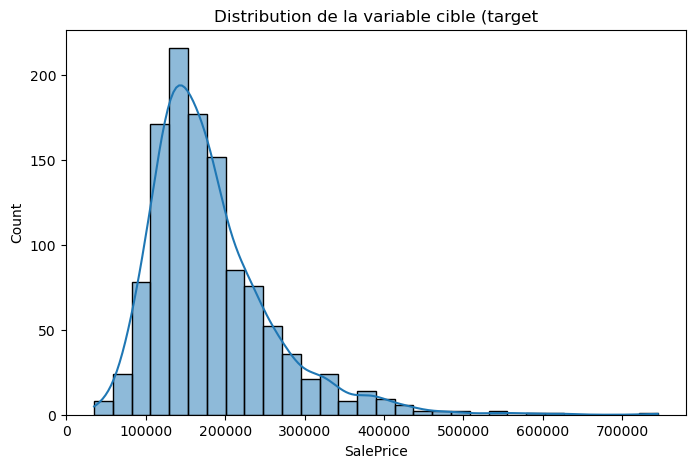

In [67]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Distribution de la variable cible (target")
plt.xlabel(TARGET_NAME)
plt.show()


On constate que notre variable cible est un asymétrique, donc un log-transform peut être envisagé pour certains modèles.

3. Distribution de quelques features numériques

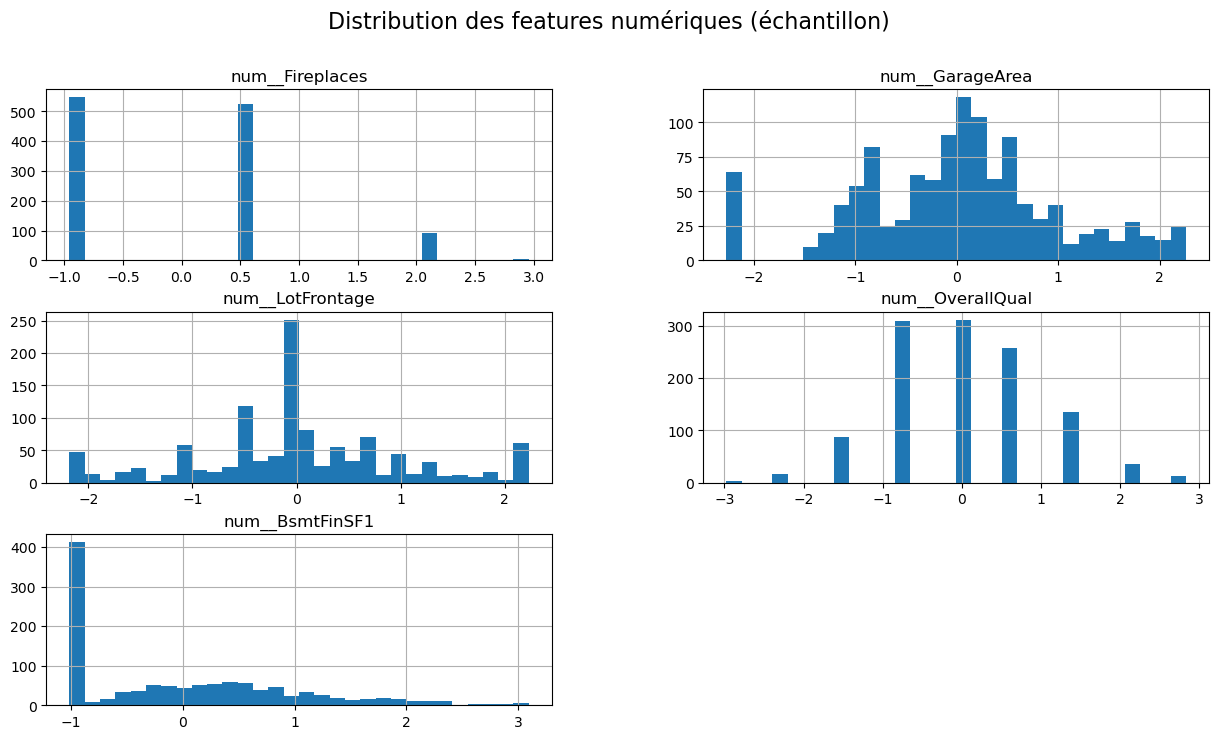

In [68]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
sample_features = numeric_features[:5]  # changer si besoin

# Plot des distributions
X_train[sample_features].hist(bins=30, figsize=(15, 8))
plt.suptitle("Distribution des features numériques (échantillon)", fontsize=16)
plt.show()

4. Corrélations avec la target

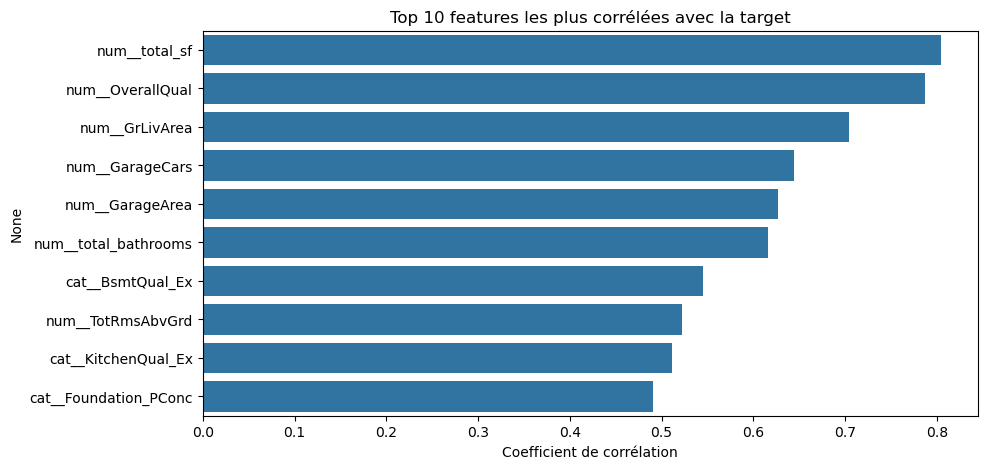

In [69]:
# Ajout temporaire de y_train à X_train pour calculer la corrélation
df_corr = X_train.copy()
df_corr[TARGET_NAME] = y_train

# Matrice de corrélation
correlations = df_corr.corr(numeric_only=True)[TARGET_NAME].sort_values(ascending=False)

# Affichage des plus corrélées
top_corr = correlations[1:11]  # on exclut la target elle-même
plt.figure(figsize=(10, 5))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 10 features les plus corrélées avec la target")
plt.xlabel("Coefficient de corrélation")
plt.show()


## 3. Baseline

### Objectif

- Créer un modèle simple (régression linéaire)
- Calculer ses performances
- Logguer les résultats dans MLflow

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np


 Fonction d’évaluation

In [71]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "r2": r2}


Fonction d'entraînement avec MLflow

In [73]:
def train_baseline_model(X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    metrics = evaluate_model(y_val, y_pred)

    # MLflow logging
    with mlflow.start_run(run_name="baseline_linear_regression"):
        mlflow.log_param("model_type", "LinearRegression")
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")

    return model, metrics


Lancer l'entraînement

In [74]:
baseline_model, baseline_metrics = train_baseline_model(X_train, y_train, X_val, y_val)
baseline_metrics

2025/07/30 22:09:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:10:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'rmse': 40460.918010943984,
 'mae': 21563.751440310014,
 'r2': 0.8260079443628938}

Affichage des résultats

In [75]:
for metric, value in baseline_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

RMSE: 40460.9180
MAE: 21563.7514
R2: 0.8260


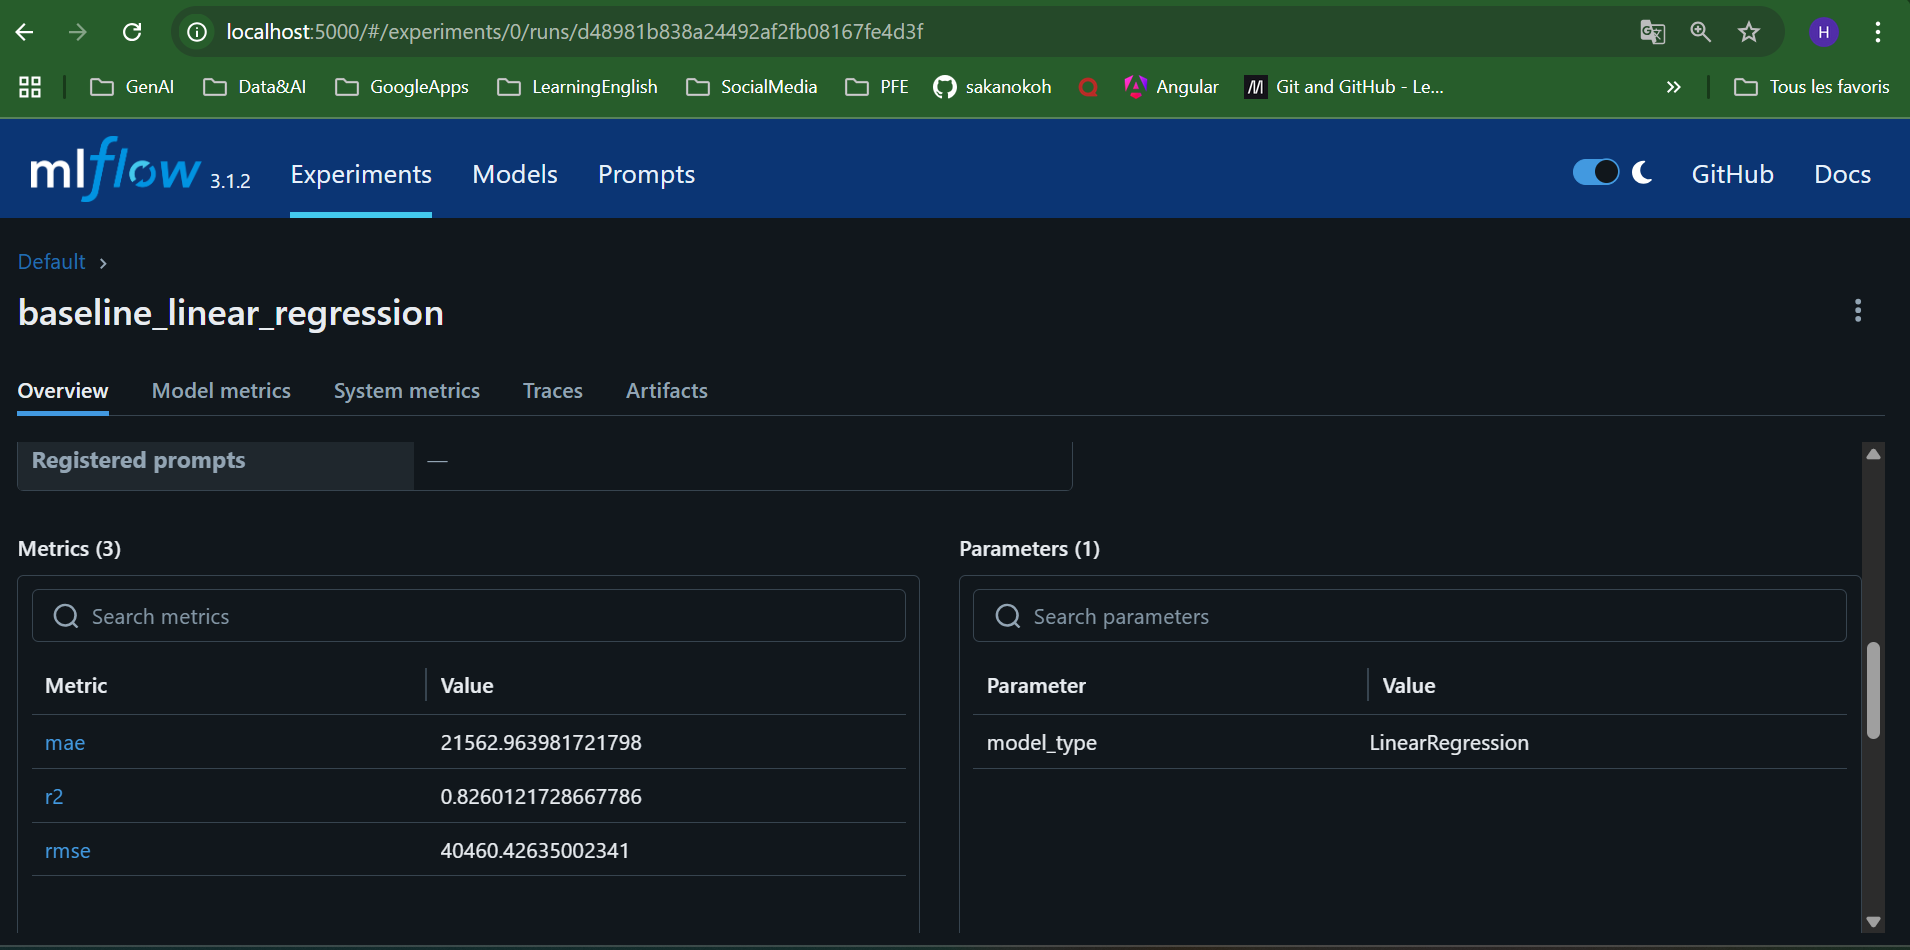

## 4. Expérimentation Modèles

 Imports utiles

In [76]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error



#### Fonction générique d'entraînement + log MLflow (modèles sklearn)

In [77]:
def train_and_log_model(name, model_class, params, X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name=name):
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        metrics = evaluate_model(y_val, y_pred)

        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")

    return model, metrics


Expérimentation 1 : Random Forest

In [78]:
rf_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "random_state": 42
}

rf_model, rf_metrics = train_and_log_model(
    name="RandomForest",
    model_class=RandomForestRegressor,
    params=rf_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)


2025/07/30 22:10:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:10:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Expérimentation 2 : XGBoost

In [79]:
xgb_params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 4,
    "random_state": 42
}

xgb_model, xgb_metrics = train_and_log_model(
    name="XGBoost",
    model_class=XGBRegressor,
    params=xgb_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)


2025/07/30 22:10:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:10:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Expérimentation 3 : SVR

In [80]:
svr_params = {
    "kernel": "rbf",
    "C": 100,
    "epsilon": 0.1
}

svr_model, svr_metrics = train_and_log_model(
    name="SVR",
    model_class=SVR,
    params=svr_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)


2025/07/30 22:10:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:11:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Expérimentation 4 : KNN

In [81]:
knn_params = {
    "n_neighbors": 5
}

knn_model, knn_metrics = train_and_log_model(
    name="KNN",
    model_class=KNeighborsRegressor,
    params=knn_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)


2025/07/30 22:11:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/07/30 22:11:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


##### Résumé des performances

In [83]:
results = {
    "RandomForest": rf_metrics,
    "XGBoost": xgb_metrics,
    "SVR": svr_metrics,
    "KNN": knn_metrics
}

for model_name, scores in results.items():
    print(f"\n{model_name}")
    for metric, value in scores.items():
        print(f"  {metric.upper()}: {value:.4f}")



RandomForest
  RMSE: 37800.1616
  MAE: 22273.7975
  R2: 0.8481

XGBoost
  RMSE: 29039.5339
  MAE: 18439.6445
  R2: 0.9104

SVR
  RMSE: 93511.1978
  MAE: 56954.8336
  R2: 0.0706

KNN
  RMSE: 44985.1882
  MAE: 24008.2877
  R2: 0.7849


#### Résultats de la comparaison des métriques de differents modèles sur MLFlow 

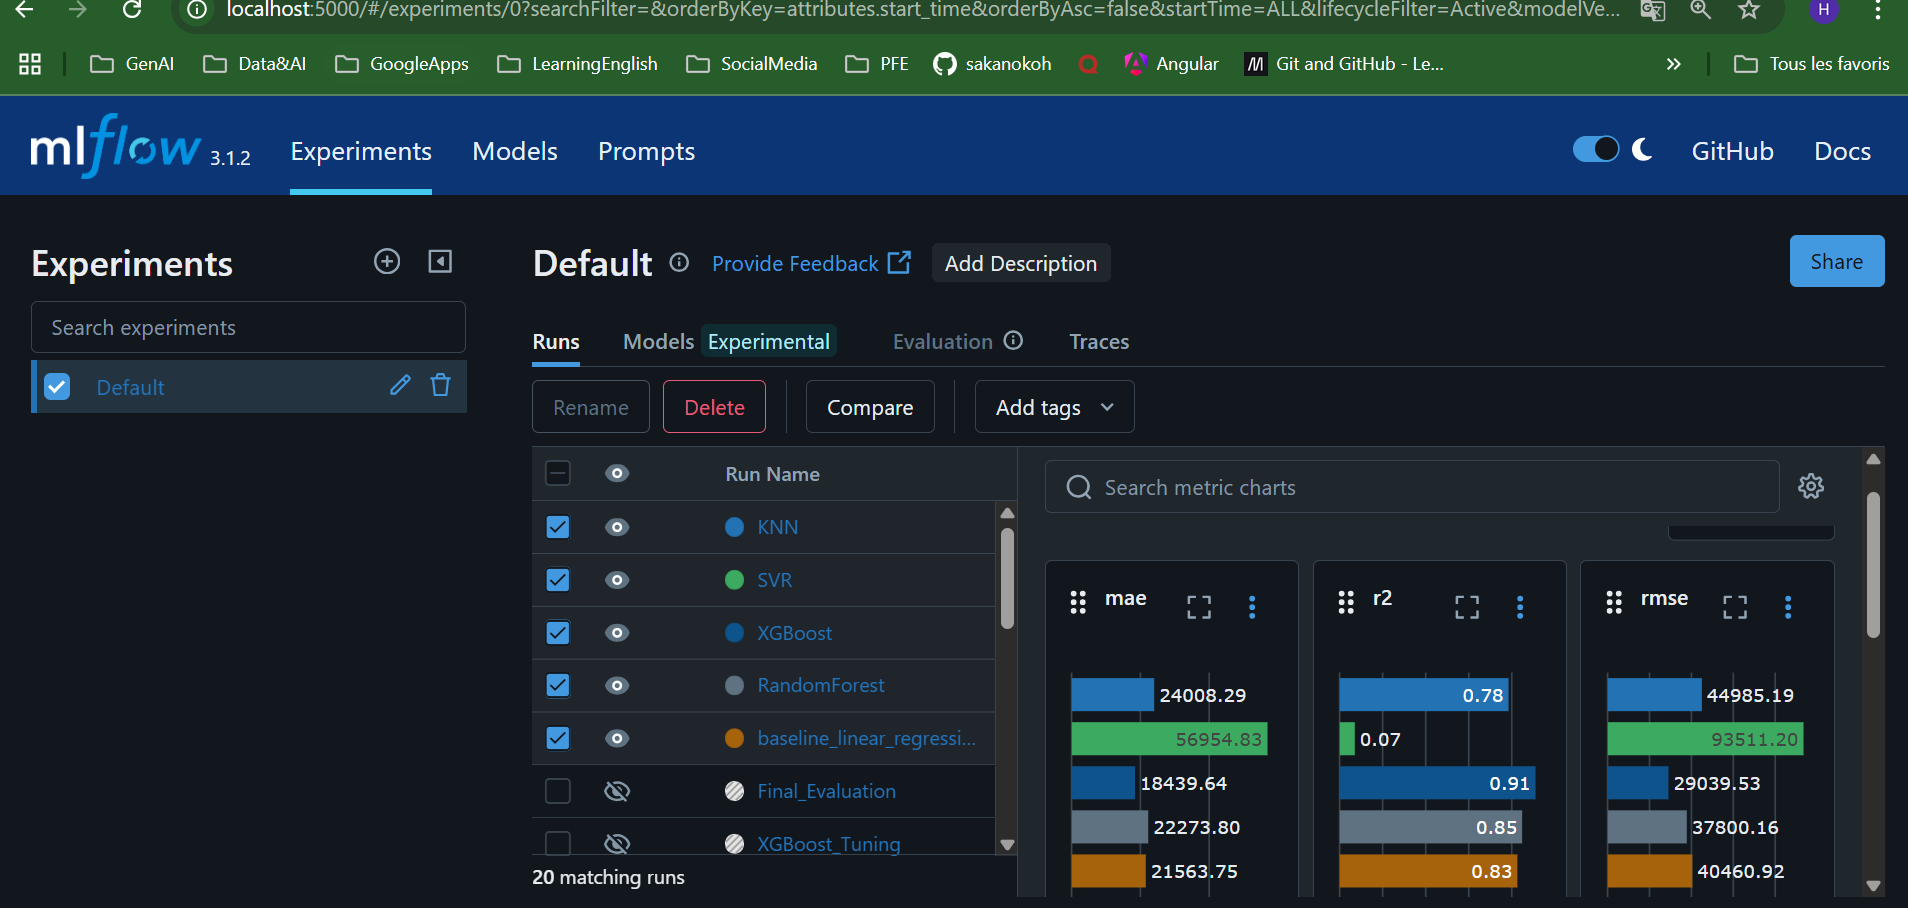

### Analyse rapide des résultats

| Modèle         | RMSE       | MAE        | R²     |
|----------------|------------|------------|--------|
| RandomForest   | 37 800     | 22 274     | 0.8481 |
| XGBoost        | **29 040** | **18 440** | **0.9104** |
| SVR            | 93 511     | 56 955     | 0.0706 |
| KNN            | 44 985     | 24 008     | 0.7849 |

👉 **XGBoost reste clairement le meilleur modèle** ici sur tous les critères :

- ✅ Plus faible **RMSE**
- ✅ Plus faible **MAE**
- ✅ Meilleur **R²**


## 5. Tuning des hyperparamètres
Nous allons maintenant optimiser les hyperparamètres du modèle XGBoost en utilisant GridSearchCV.

L’objectif est d’améliorer encore ses performances tout en logguant les résultats avec MLflow

#### Définition de la grille de recherche

In [89]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1],
}


Recherche par validation croisée + MLflow Logging

In [90]:
with mlflow.start_run(run_name="XGBoost_Tuning"):

    xgb = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Meilleurs hyperparamètres
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Évaluation sur la validation
    best_model = grid_search.best_estimator_
    val_preds = best_model.predict(X_val)
    eval_metrics = evaluate_model(y_val, val_preds)

    # Log MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric("rmse", eval_metrics["rmse"])
    mlflow.log_metric("mae", eval_metrics["mae"])
    mlflow.log_metric("r2", eval_metrics["r2"])
    mlflow.sklearn.log_model(best_model, "best_xgb_model")

    print(f"Validation RMSE: {eval_metrics['rmse']:.2f}")
    print(f"Validation MAE: {eval_metrics['mae']:.2f}")
    print(f"Validation R²: {eval_metrics['r2']:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}


2025/07/30 22:24:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation RMSE: 29359.46
Validation MAE: 18274.88
Validation R²: 0.9084


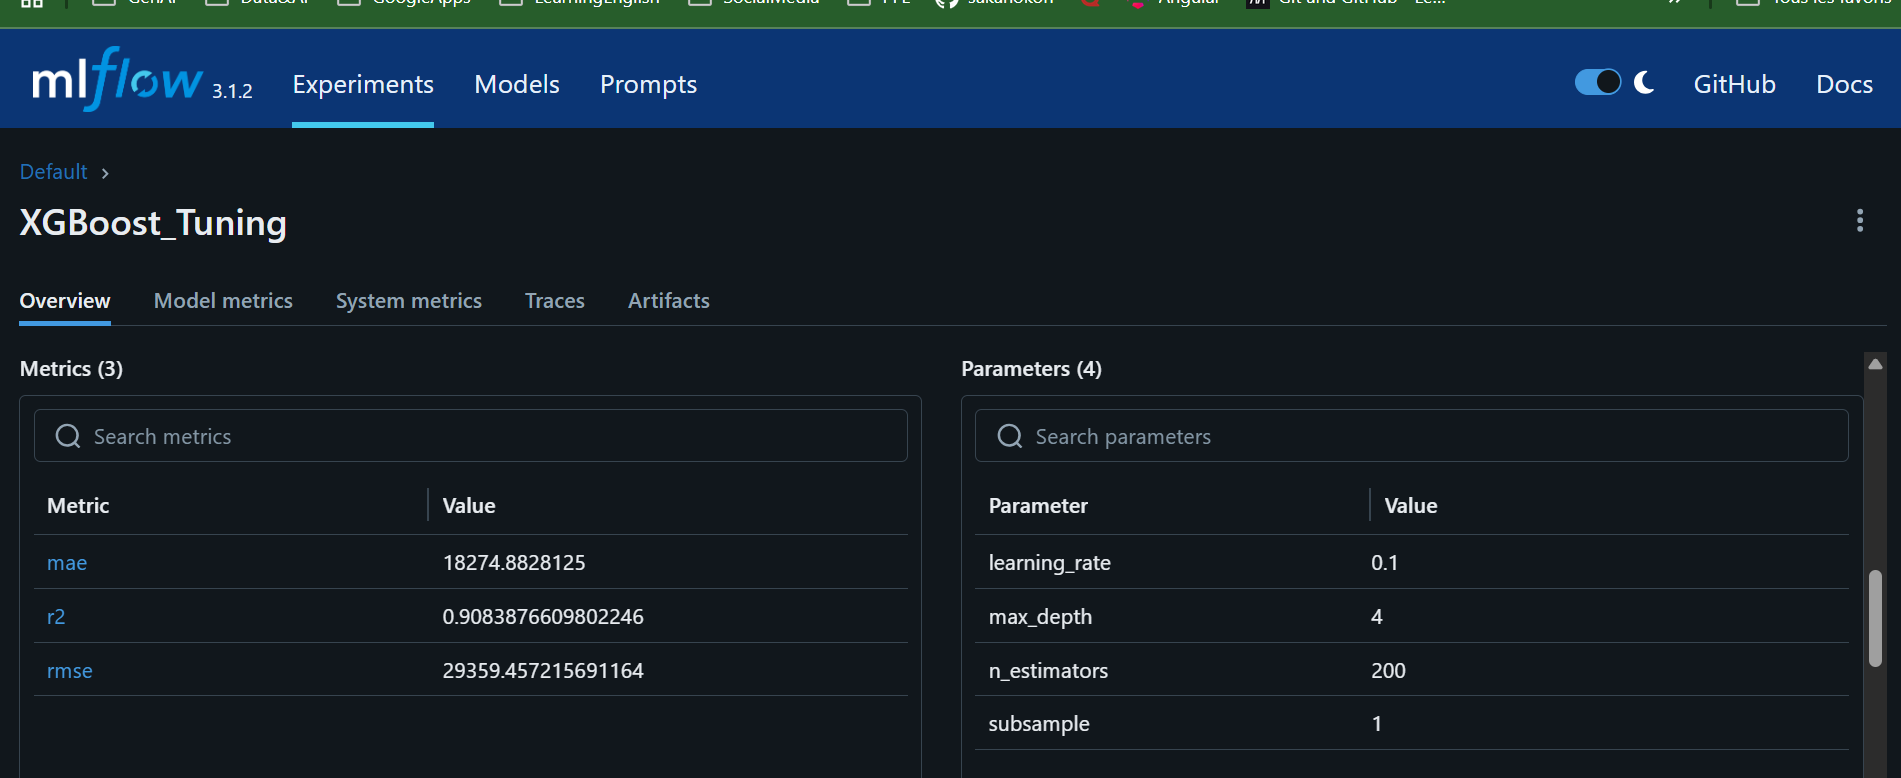

## 6. Évaluation finale

On évalue maintenant **le meilleur modèle** sur un jeu **test** **jamais vu**.

In [91]:
# Prédictions finales
y_pred = best_model.predict(X_test)

# Métriques
rmse, mae, r2 = evaluate_model(y_test, y_pred).values()

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 21934.6929
Test MAE: 14368.7021
Test R²: 0.9179


Visualisations

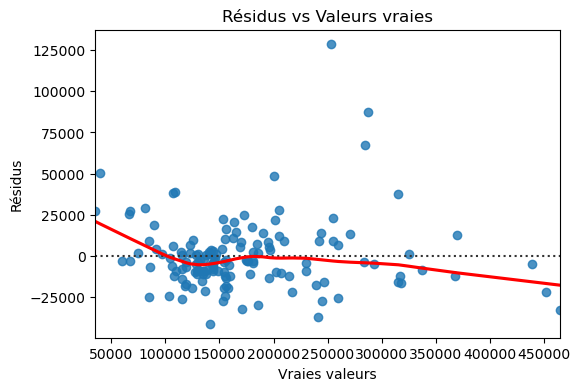

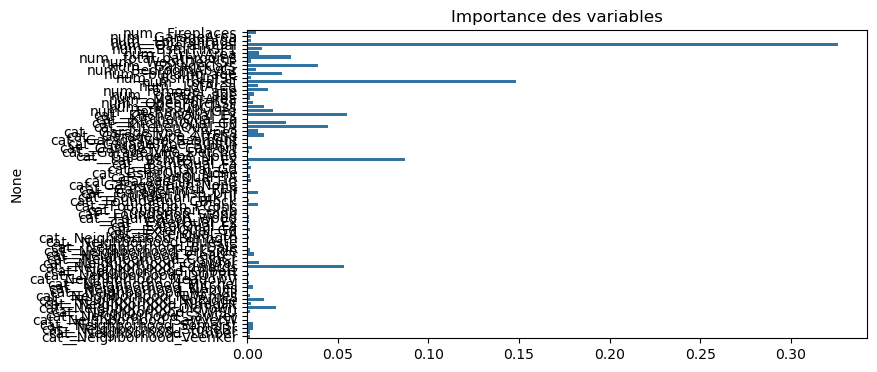

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Résidus
plt.figure(figsize=(6,4))
sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={"color": "red"})
plt.xlabel("Vraies valeurs")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs vraies")
plt.show()

# Importance des variables
importances = best_model.feature_importances_
plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=X_test.columns)
plt.title("Importance des variables")
plt.show()


Logguer tout dans MLflow

In [93]:
with mlflow.start_run(run_name="Final_Evaluation"):

    mlflow.log_metric("test_rmse", rmse)
    mlflow.log_metric("test_mae", mae)
    mlflow.log_metric("test_r2", r2)

    mlflow.sklearn.log_model(best_model, "final_model")


2025/07/30 22:26:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 22:26:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


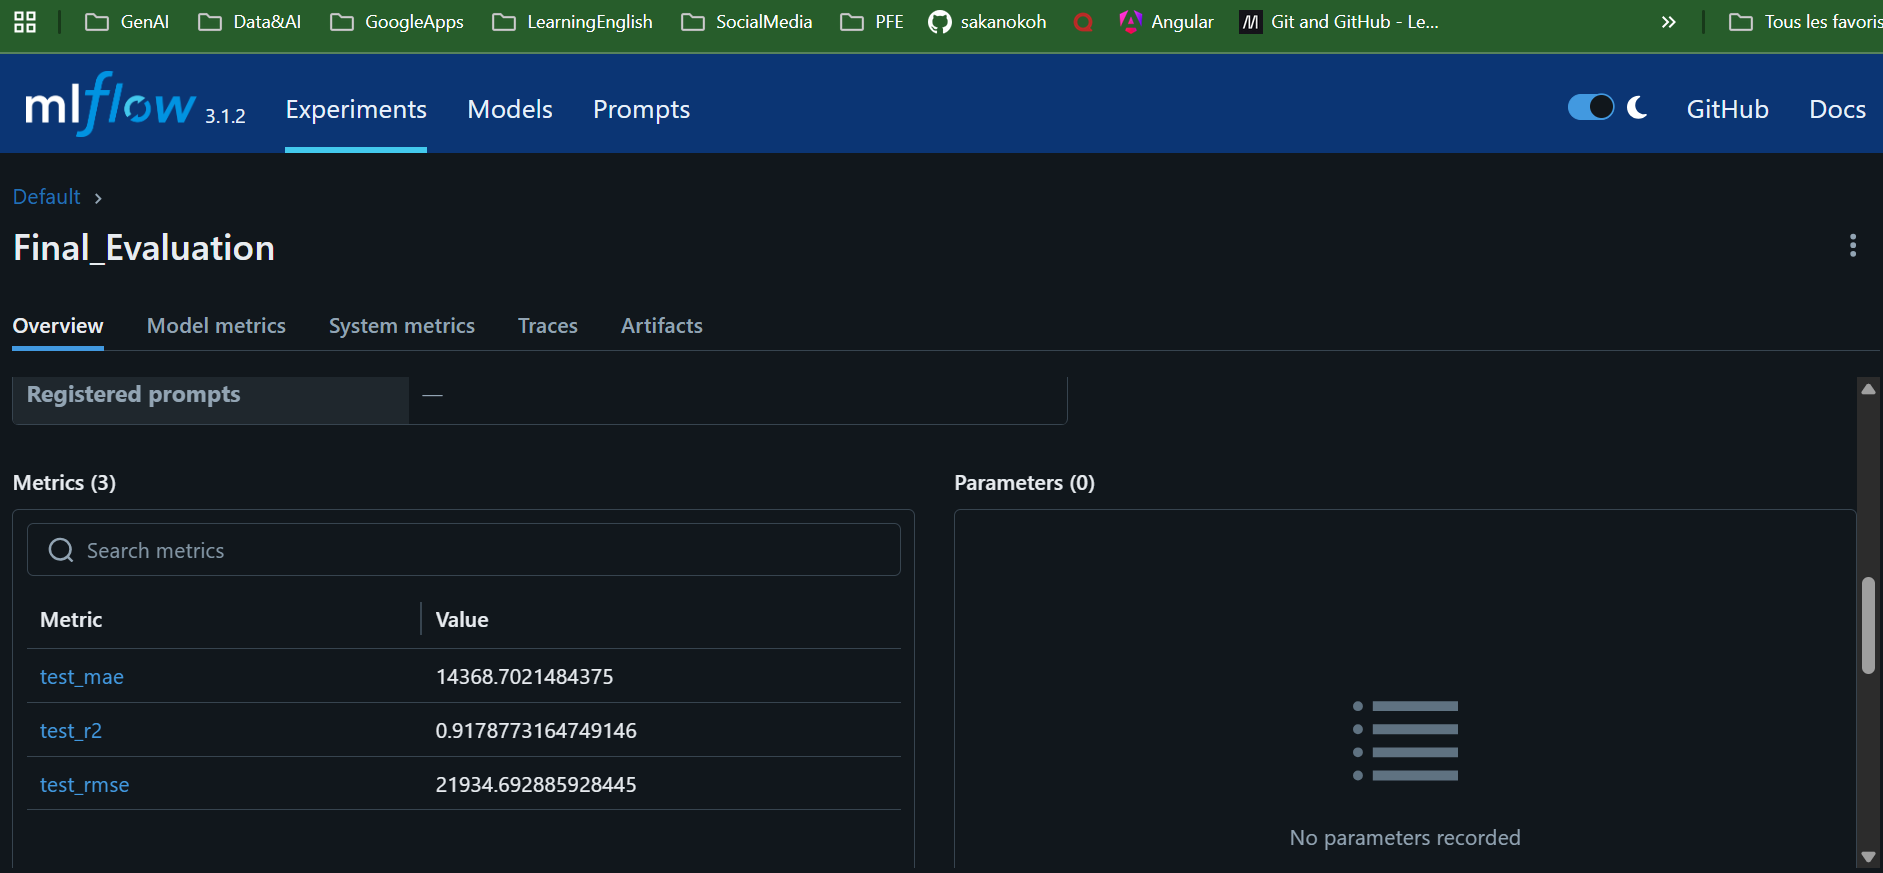

## 7. Export & Suivi

In [94]:
import joblib

# Sauvegarde en local
joblib.dump(best_model, "./../models/best_model.pkl")


['./../models/best_model.pkl']